# Modelo Detección Drowsiness (Clasificación)

## **1. Introducción**
"En el año 2020 perdieron la vida en España, en accidentes de tráfico, 1.370 personas y en toda la Unión Europea el número de fallecidos fue de alrededor de 18000.”

En la primera parte de este proyecto queremos intentar ajustar un modelo para poder detectar periodos de somnolencia durante la conducción, para ello vamos a usar el Drowsiness Detection Dataset disponible en Kaggle, este es un dataset de aproximadamente 41790 imágenes extraidas del dataset **Real-Life Drowsiness Dataset** (originalmente son videos). Este dataset se ha empleado para el paper “Detection and Prediction of Driver Drowsiness for the Prevention of Road Accidents Using Deep Neural Networks Techniques” que posteriormente comentaremos.

Vamos a ver algunas de las imágenes y sus labels

**Drowsiness**

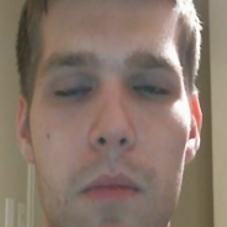

**Non drowsiness**

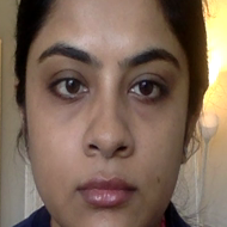

## **2. Aproximación al problema**

Parece fácil, siguiendo el paper anteriormente comentado fiteamos una CNN esperando que el modelo aprenda de aquellas características que desvelan episodios de somnolencia (ojos cerrados, mirada cansada ...). Para ello hay que esclarecer un poco más la pipeline, al ser una tarea de clasificación es importante centrarnos en lo que queremos clasificar, por lo que vamos a emplear una primera CNN para obtener el recorte de la imágen con solo el rostro de la misma, a partir de aquí podemos reducir muchísima variabilidad ante situaciones en las que la persona está encuadrada en diferentes lugares en la imagen. Adjunto una imágen de lo que sería la pipeline:

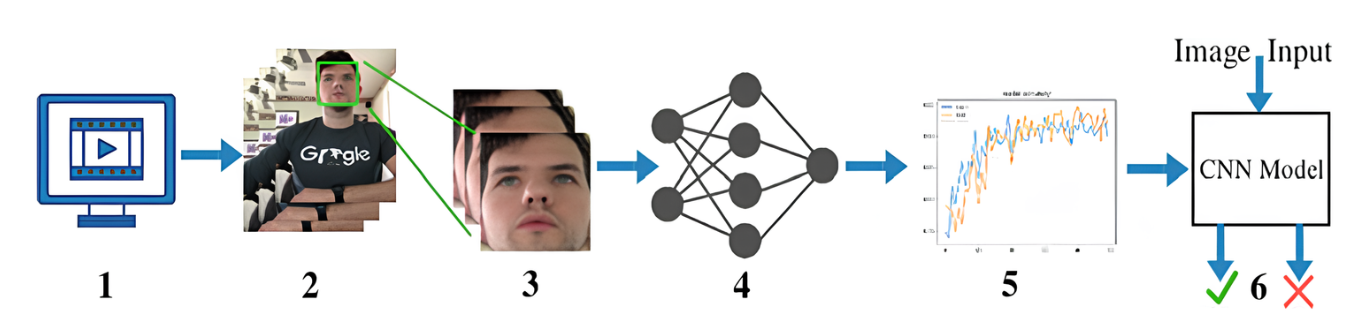

La pipeline parte del **vídeo en streaming** que se debe captar del usuario (1), del que se extraen fotogramas. En cada frame se **detecta el rostro** con un modelo de detección en tiempo real (2) y se **recortan regiones de interés** centradas principalmente en la cara (3). Esas crops se envían a un **modelo CNN** (4) del que nos vamos a encargar de entrenar (5). El modelo produce una **probabilidad de somnolencia** y una decisión binaria (**somnoliento / no somnoliento**) (6). 

*Código*

- **00_download_models.py**, se encarga de descargar un modelo de detección de rostros ya entrenado, lo llamaremos **yolov11s-face**.
- **01_download_datasets.py**, se encarga de descargar DDD directamente desde kaggle a la carpeta de datasets/

## **3. Experimentación**

A partir de ahora ya podemos encargarnos de preprocesar el dataset e intentar ajustar un modelo para poder predecir este tipo de imágenes. Lo primero es hacer un split del mismo y generar el dataset con la estructura requerida por YOLO. Para ello vamos a splittear el dataset en train/test/val empleando **02_transform_ddd_yolo.py**, lo que nos dejará en transformed_datasets/ el dataset con las especificaciones requeridas por YOLO (estructura de carpetas para clasificación). Para realizar los splits se ha empleado un ratio 70/20/10 para train/val/test, respectivamente.

*Código*

- **02_transform_ddd_yolo.py**, se encarga de transformar el dataset dejándolo preparado para alimentar a YOLO.

Una vez tenemos preparados los datos para enviárselos a YOLO debemos experimentar cual de los diferentes tamaños de YOLO emplear:

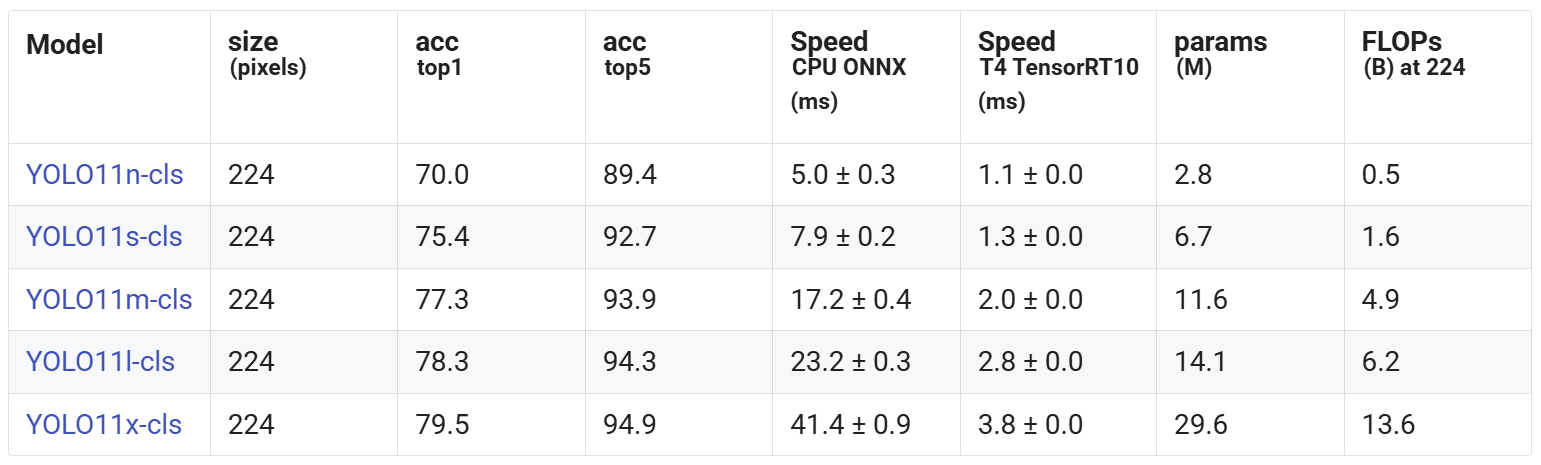


El compromiso principal es entre **precisión** y **latencia/coste computacional**. Los modelos más grandes (*m*, *l*, *x*) alcanzan una ligera mejora en *accuracy top-1* (de **77.3 %** a **79.5 %**), pero a costa de un incremento notable en **parámetros** y **FLOPs** (hasta **29.6 M** y **13.6 B**) y una **latencia mayor** (≈ **2.0–3.8 ms** en GPU T4; **17–41 ms** en CPU ONNX).  
Esto reduce el margen disponible para el resto de la *pipeline*.  

Por otro lado, el modelo **YOLO11n-cls** es extremadamente rápido (≈ **1.1 ms** en T4; **5 ms** en CPU), pero su precisión cae significativamente (*top-1* = **70.0 %**), lo que aumenta el riesgo de **falsos negativos** en escenarios de seguridad.  

Por ello se opta por **YOLO11s-cls**, que ofrece un equilibrio óptimo:  
mejora la precisión hasta **75.4 %**, mantiene una **latencia baja** (≈ **1.3 ms** T4; **7.9 ms** CPU) y un coste moderado (**6.7 M** parámetros; **1.6 B** FLOPs).  
En la práctica, proporciona el **mejor balance entre rendimiento y velocidad** para operar en **tiempo real**.

Tras entrenar con el modelo small de YOLOv11 para clasificación (a través de **03_train_ddd_yolo.py**) podemos ver como el clasificador entrena de forma perfecta. Podemos pensar en que se ha producido overfitting, pero en las imágenes de test también mantiene esta precisión. 

**Nota**: en src/config.py se pueden encontrar los hiperparámetros que mejores resultados han ofrecido para esta tarea tras un proceso de búsqueda.

Una vez entrenado podemos probar a inferir en tiempo real a través de nuestra webcam mediante **05_launch_drowsiness_detector.py**, para ello se emplea la pipeline comentada antes, **yolov11s-face** + el modelo que acabamos de entrenar. 
Probando a simular situaciones de somnolencia aquellas más obvias son captadas correctamente por el modelo pero cuando intentamos mostrar una actitud de atención el modelo no sabe muy bien clasificar esto y varía mucho su respuesta entre clases.

## **4. Conclusión**

Por lo tanto me replanteo si este problema esta bien enfocado, llego a una conclusión clara: 

La somnolencia del conductor no es un estado observable en una **instantánea**: es un fenómeno **temporal** que emerge de patrones a lo largo de minutos (tasa y duración de parpadeos, PERCLOS sostenido, microcabeceos, bostezos prolongados, deriva de la mirada, variación postural) y del **contexto acumulado** (tiempo continuo de conducción, ritmo circadiano, fatiga previa). Un clasificador sobre imágenes estáticas obliga a inferir una etiqueta **estado** a partir de un solo fotograma, donde señales clave quedan invisibles o ambiguas (por ejemplo los ojos cerrados no son causa directa de somnolencia, pueden ser producto del pestañeo natural). Además, al entrenar con “snapshots” se ignoran la **autocorrelación** y la **causalidad pasado→futuro**, lo que induce fugas de información en splits aleatorios y resultados artificialmente optimistas. Por tanto, el planteamiento correcto es **en streaming**, modelando secuencias y agregando evidencia en el tiempo (ventanas deslizantes y métricas temporales como PERCLOS, inter-blink interval, duración de bostezos), con arquitecturas que capturen dependencia temporal (TCN/Transformers/LSTM o CNN 3D) y evaluación causal (time-series split). Solo así se alinea el aprendizaje con la naturaleza del problema.

Para concluir considero que la propuesta de los autores de esta escisión del Real-Life Drowsiness Dataset parece no se el enfoque correcto, sin embargo esta fue aceptada en el WITS2020 (https://doi.org/10.1007/978-981-33-6893-4_6)


---

# Modelo Detección Colisión Frontal (Segmentación de instancias)

## **1. Introducción**

Este segundo problema consiste en aborda la detección temprana de riesgo de colisión frontal: es decir, detectar con antelación aquellas situaciones en las que un peatón o vehículo entra en la trayectoria de nuestro coche de modo que, a la velocidad actual, la distancia de frenado y el tiempo de reacción disponibles no bastan para evitar el impacto. Para ello vamos a simular este entorno de conducción urbana con CARLA.

CARLA (Car Learning to Act) es un simulador open-source de conducción autónoma basado en Unreal Engine que permite recrear entornos urbanos realistas, con control total sobre mapas, tráfico, peatones, clima, iluminación y sensores. Ofrece APIs en Python/C++ para orquestar escenarios, registrar ground truth (cajas, segmentación, profundidad), y montar un ego-vehicle con una suite de sensores virtuales (cámaras RGB, profundidad, LiDAR, radar, GNSS, IMU, etc.). Se está desarrollando en la UAB y suele incorporar las tecnologías más novedosas de Nvidia.

Un modelo de instance segmentation es ideal para este caso, permitiendo inferir peatones y vehículos de forma precisa para poder usar esta información en nuestro módulo de detección de colisión frontal.

Mediante instance segmentation se asigna una **máscara de píxeles** a **cada objeto individual** (no solo una caja ni una clase global), diferenciando, por ejemplo, *coche A* de *coche B* o *peatón 1* de *peatón 2*, incluso cuando están **ocultos parcialmente** o muy cerca entre sí. En detección de **vehículos**, esto permite obtener el contorno real (mejor que una caja rectangular que incluye fondo), estimar su **área proyectada** y su posición exacta en el carril; en **personas**, delimita el cuerpo completo y separa varios peatones pegados, por ejemplo, en un paso de cebra. Estas máscaras por instancia se pueden **proyectar por homografía** a vista cenital para medir **solape preciso con la zona de riesgo**, calcular distancias laterales/longitudinales y alimentar métricas como **TTC** o invasión de carril. Resultado: menos **falsos positivos/negativos** que con solo *bounding boxes* y señales geométricas más fiables para el módulo de **detección de riesgo de colisión frontal**.


## **2. Aproximación al problema**

Para este problema únicamente nos vamos a servir de una cámara perspectiva y un sistema de actuadores para poder activar los frenos del vehículo. Situando la cámara de la misma forma que los sistemas de City Active Brake (detrás del espejo retrovisor) conseguimos una buena visión de la parte frontal del vehículo, pero el tener una cámara perspectiva complica mucho las cosas:
- Como primer problema existe un punto muerto en la parte de la matrícula, este problema es irremediable al emplear una única camara perspectiva desde la posición comentada

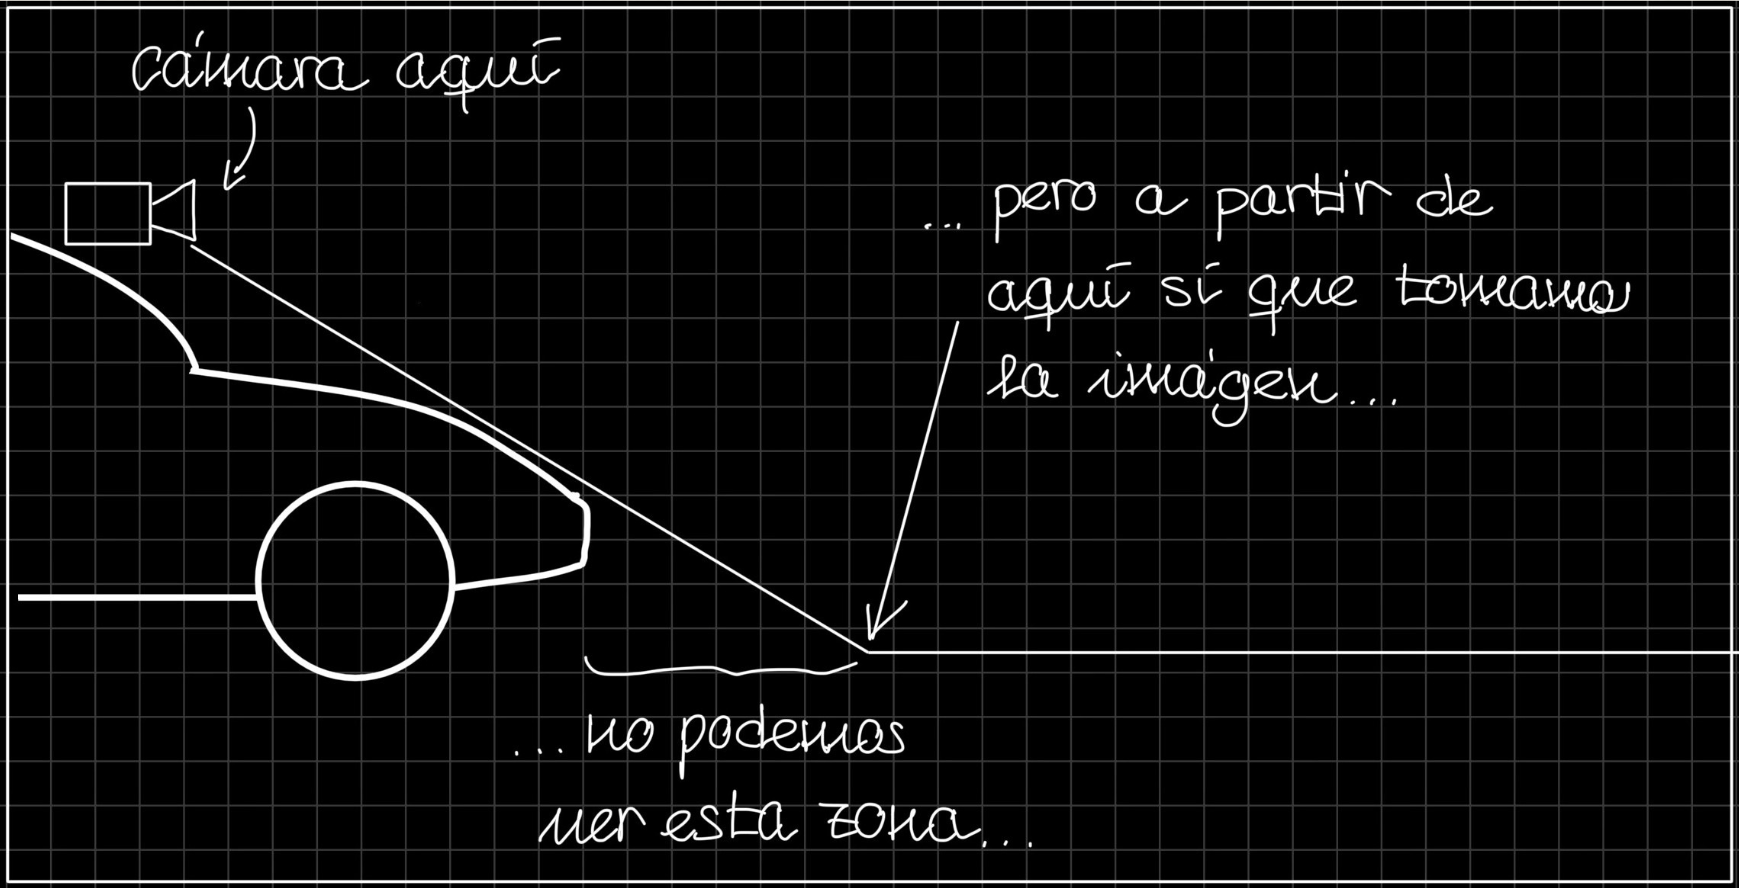
- Las imágenes captadas, producto de este tipo de sensores, están deformadas, todo tiende hacia un punto en la imágen, llamado el punto de fuga. Esto provoca que las alturas de cualquier objeto sean inversamente proporcionales a la distancia que existe entre el objeto y el sensor. Por suerte técnicas clásicas de visión por computador pueden ayudar a la tarea.

**Problema de Shape Reconstruction**

Mapear la cónica dual (puntos circulares) de la imágen distorsionada a su posición canónica. Se puede encontrar más información acerca de este proceso en el notebook testing/notebooks/rectify_horizontal_plane.ipynb (aquí se ha realizado affine recontruction, similar pero no recupera la imágen en el espacio euclídeo). Principalmente el shape reconstruction consiste en llevar la cónica métrica (cónica dual del infinito, i.e., los puntos circulares) de la imagen a su forma canónica, de modo que el plano observado recupere una geometría euclídea: paralelismo, ortogonalidad real y escala uniforme (quedando indeterminada solo una semejanza global: rotación, traslación y un factor de escala). En la práctica, se procede en dos pasos: (1) rectificación afín, estimando la línea del infinito a partir de dos familias de paralelas para eliminar la distorsión proyectiva; y (2) rectificación métrica, imponiendo restricciones de ortogonalidad (p. ej., dos pares de direcciones perpendiculares) para recuperar la cónica métrica y obtener la homografía que restaura ángulos y proporciones.

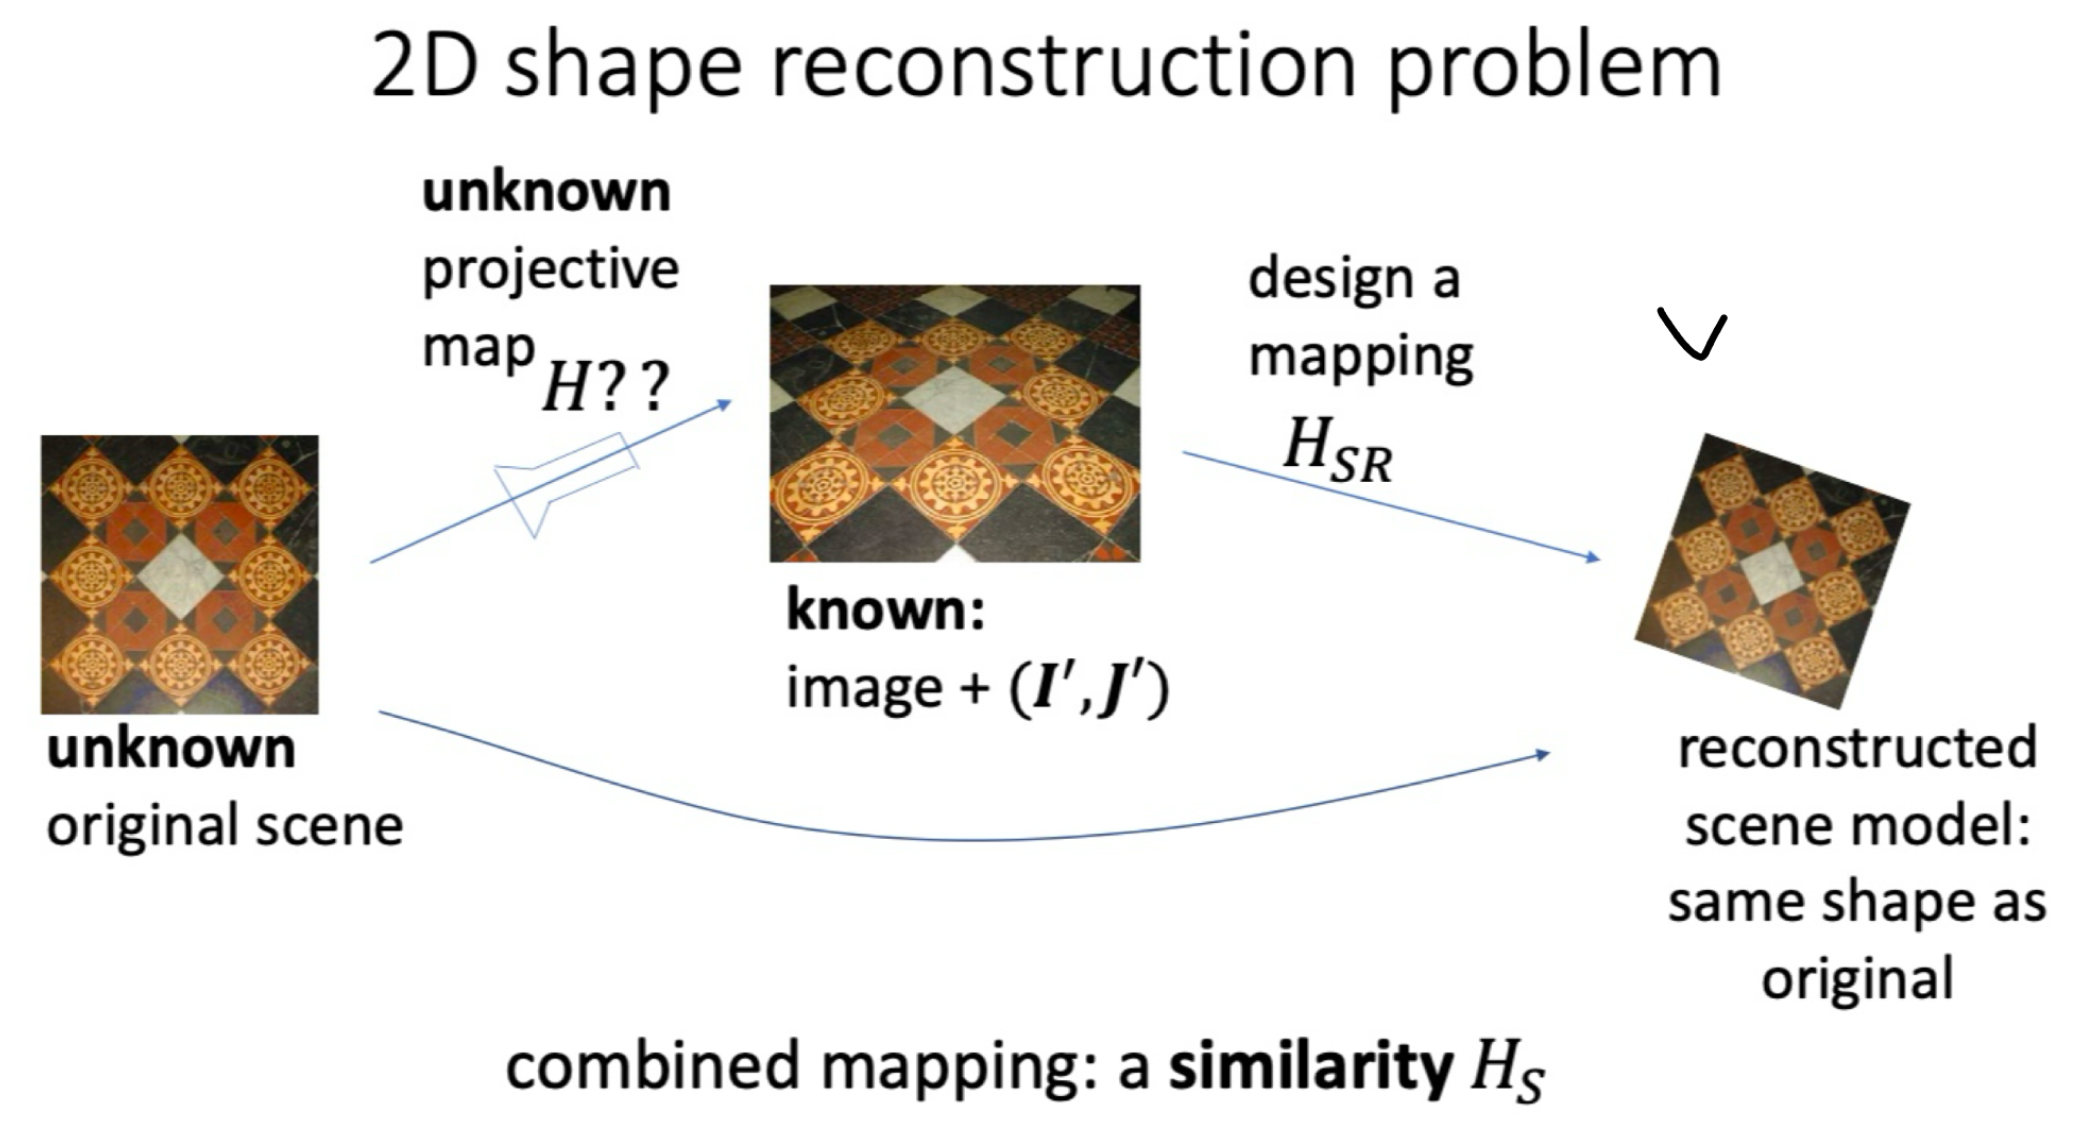

Ejemplo de rectificación sobre imágen en el simulador de CARLA:

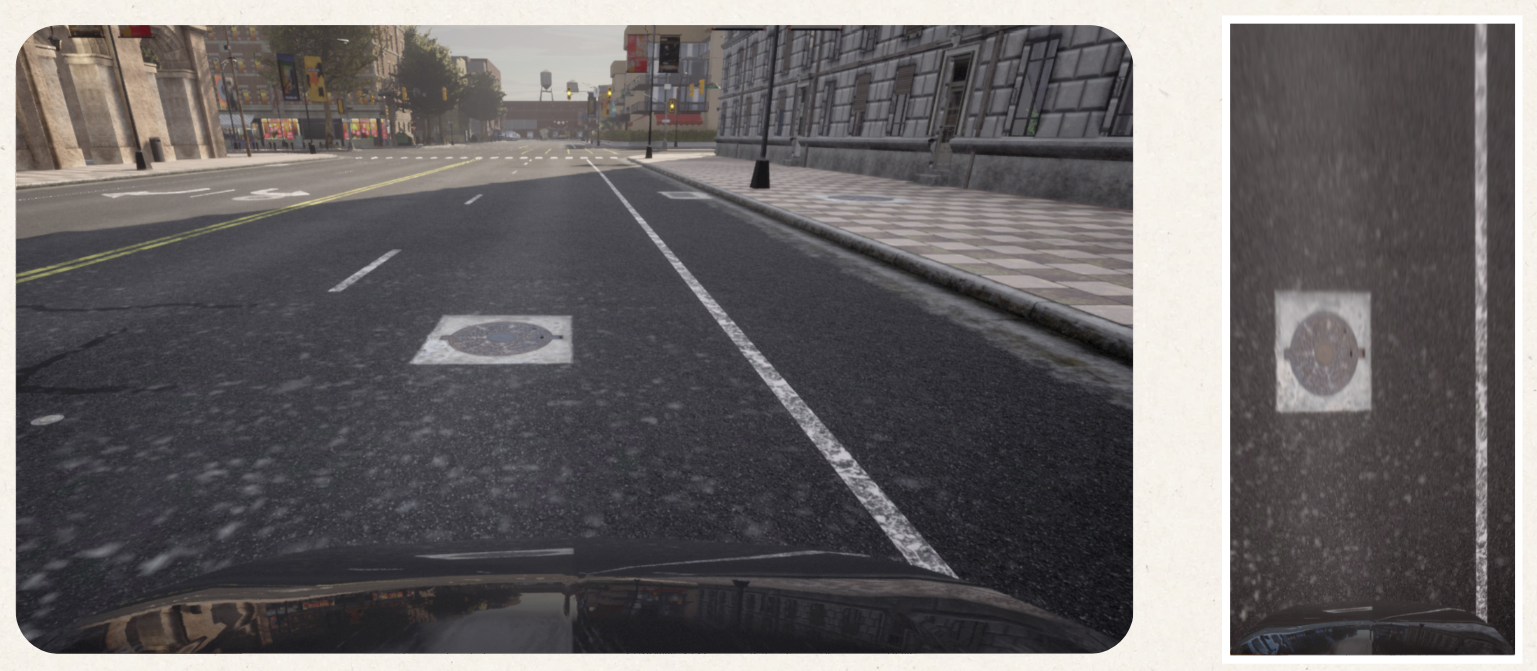


## **3. Experimentación**

La primera tarea para resolver este problema es recolectar el dataset que vamos a usar para poder entrenar este modelo de instance segmentation, el simulador de CARLA ofrece múltiples sensores, un sensor rgb y un sensor de instance segmentation son necesarios para poder guardarnos las imágenes de la cámara y todas las instancias con sus clases presentes en la imagen. Un total de 10000 imágenes han sido capturadas de varios mapas disponibles para aumentar la diversidad de escenarios. Este dataset generado artificialmente está disponible en el siguiente repositorio de GitHub: https://github.com/IronDog421/rfa_dataset (agradecería considerar el tiempo de cómputo que supone su creación:  recolección, sincronización de sensores para la captura de imágenes, transformación a yolo-compatible labels y hacerlo disponible mediante un repositorio GitHub)

Mediante **01_download_datasets.py**, podemos descargar este dataset directamente desde el repositorio a la carpeta de datasets/. No es necesario ningun procesamiento extra, pues ya se ha realizado previamente para subirlo a GitHub.

Una vez ya tenemos el dataset preparado para entrenar con YOLO, debemos elegir que modelo vamos a usar para segmentación semántica:

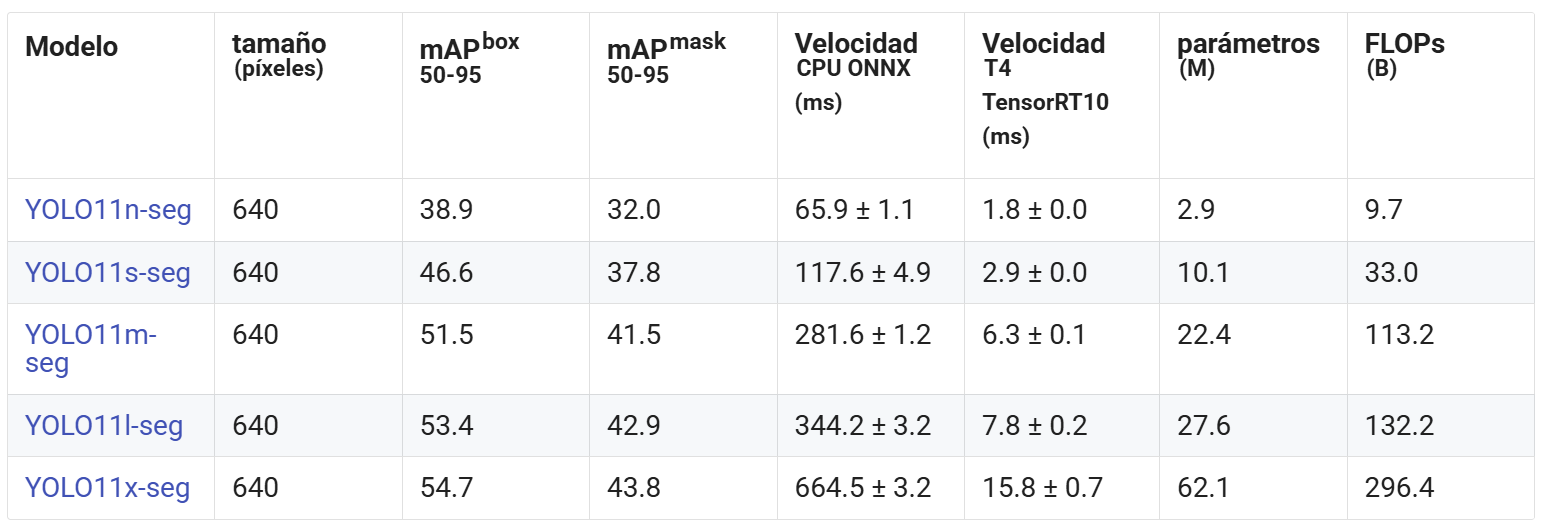

De la misma forma que antes se opta por el modelo small, **YOLO11s-seg**, que ofrece un equilibrio óptimo entre precisión y tiempo de inferencia/parámetros. Mediante **03_train_rfa_dataset_yolo.py** se realiza el entrenamiento con los parámetros subóptimos encontrados para el modelo small.

**Nota**: en src/config.py se pueden encontrar los hiperparámetros que mejores resultados han ofrecido para esta tarea tras un proceso de búsqueda.

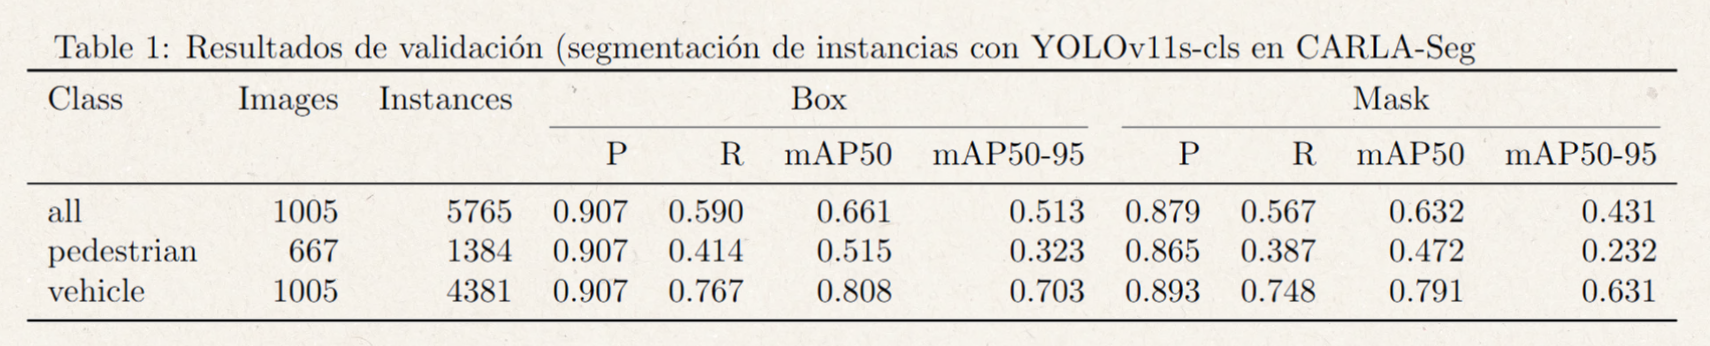

Aunque las métricas pueden parecer bajas, es importante considerar que el entrenamiento y la validación se realizaron en un entorno simulado con CARLA, utilizando una cámara en perspectiva. En este tipo de vista, la altura aparente de los objetos disminuye con la distancia, haciendo que aquellos situados cerca del punto de fuga (vanishing point) sean difíciles de detectar o segmentar correctamente. Además, el simulador genera objetos con condiciones de iluminación variables o con texturas poco distintivas, que el modelo intenta etiquetar igualmente, lo que puede introducir ruido y reducir las métricas globales. Aun así, el modelo muestra un comportamiento sólido en la clase vehicle, con buena segmentación y precisión, lo que es especialmente relevante para el módulo de detección de riesgo de colisión frontal. A continuación podemos observar labels y predicciones para verificar esto:

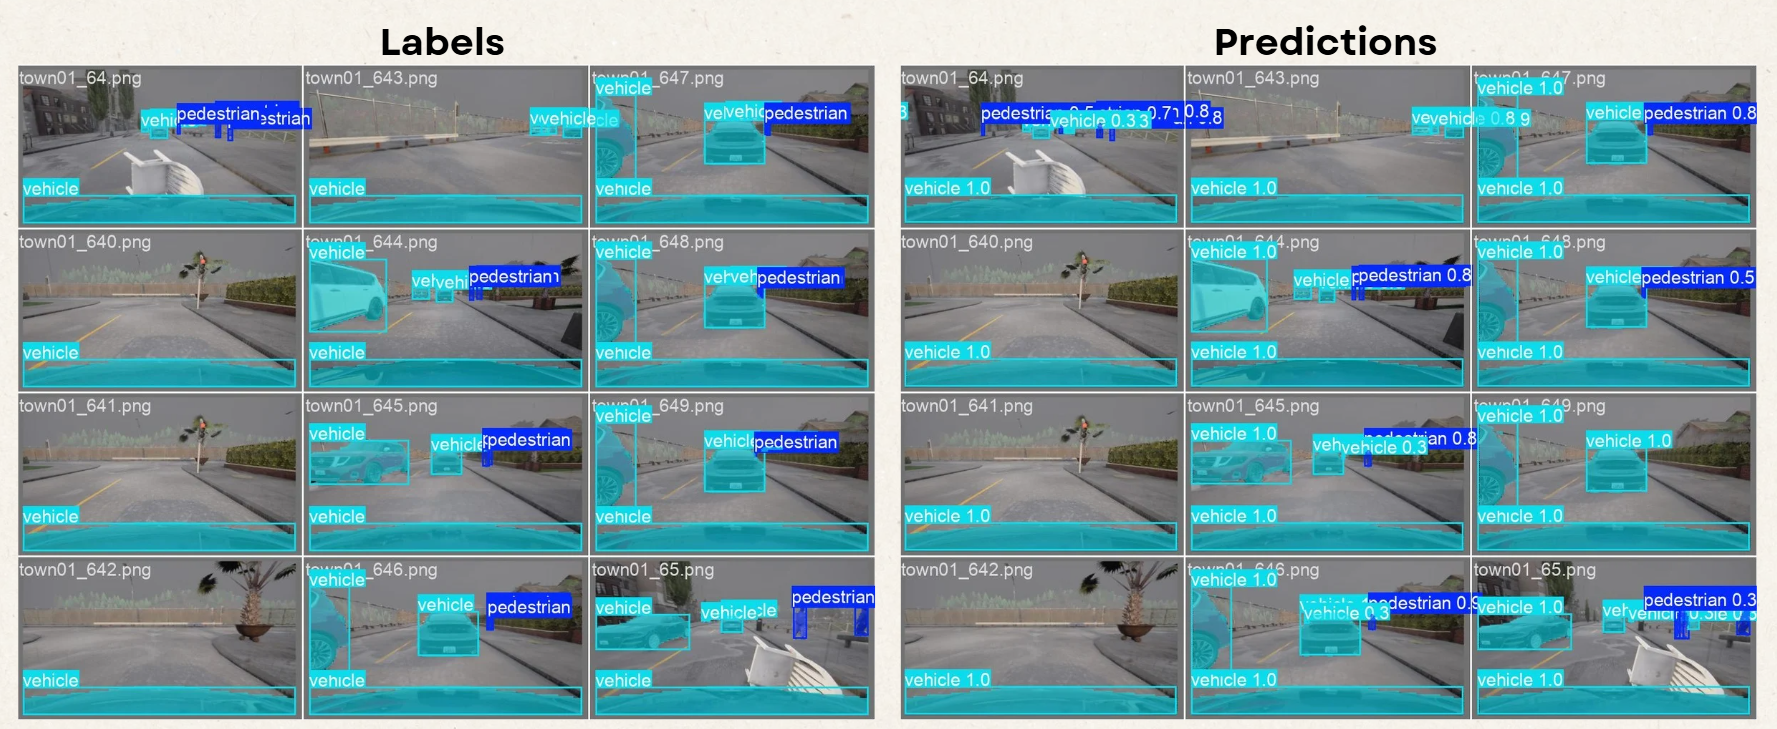


Finalmente, con el modelo entrenado la detección se realiza en tiempo real capturando la ventana del simulador y procesando cada fotograma con el modelo de segmentación entrado que identifica peatones y vehículos. Cada detección se proyecta mediante la homografía computada anteriormente **homografía** a una vista cenital del entorno, lo que permite saber con precisión si un objeto está dentro de la **zona de riesgo** situada frente al coche, que gracias a esta rectificación podemos situarla con confianza a una cierta distancia con bastante precisión y fidelidad a la realidad (rectificación métrica permitiría una precisión absoluta). Si alguna máscara o caja detectada invade esa zona más de un cierto porcentaje, el sistema interpreta que existe **riesgo de colisión** y activa automáticamente una **frenada de emergencia** simulada por teclado y una posterior marcha atrás y alejamiento respecto al vehículo/peatón de enfrente.




Video disponible del funcionamiento: https://youtu.be/59sldph0dXY